In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

%matplotlib inline

## Loading Data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving transactions.csv to transactions.csv
Saving users.csv to users.csv


In [0]:
transaction= pd.read_csv("transactions.csv",parse_dates=['CREATED_DATE'])
users=pd.read_csv("users.csv",parse_dates=['CREATED_DATE'])

In [0]:
print ("Unique users in transactions:",transaction['USER_ID'].nunique())
print ("Unique users in Users:", users['ID'].nunique())

Unique users in transactions: 8021
Unique users in Users: 9944


Note: From the count of user_id which is the foreign key to both tables to join, there're only 8021 users counting at trsanctions. Hence we only consider these existing in the trasaction table.

In [0]:
## turn column name into lower case
transaction.columns = map(str.lower,transaction.columns)
users.columns = map(str.lower,users.columns)

In [0]:
## Map data in two tables
data = transaction.merge(users,how="left", 
                         left_on="user_id",
                         right_on="id").drop(["id_y","state_y"],axis=1).rename(columns={"state_x":"tran_state",
                                                                                "created_date_x":"tran_created",
                                                                                "id_x":"tran_id",
                                                                                "created_date_y":"acc_created"})

In [6]:
data['is_fraudster'].value_counts()

False    624828
True      13914
Name: is_fraudster, dtype: int64

Note: It's obvious that we got an imbalanced data where fraudument trasactions only take small part of the sample data, we should be consious that it has to be handled wihle training model 


# Explore Data


In [7]:
data.groupby('is_fraudster')['tran_state'].value_counts()

is_fraudster  tran_state
False         COMPLETED     532673
              DECLINED       38997
              REVERTED       35266
              FAILED         14999
              PENDING         2424
              CANCELLED        468
              RECORDED           1
True          COMPLETED      10053
              DECLINED        2097
              REVERTED        1141
              FAILED           597
              CANCELLED         20
              PENDING            6
Name: tran_state, dtype: int64

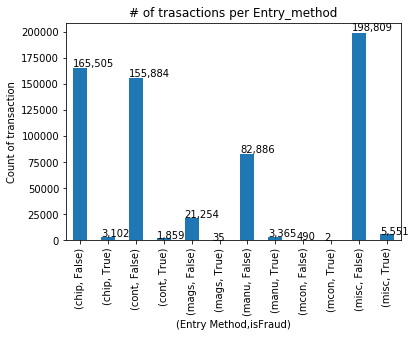

In [8]:
## let's see there is any difference in fraudument transactions in different entry method
ax = data.groupby(['entry_method','is_fraudster']).size().plot(kind="bar")
ax.set_title("# of trasactions per Entry_method")
ax.set_xlabel("(Entry Method,isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

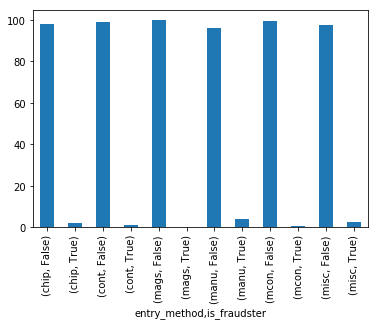

In [0]:
perc_entry = data.groupby(['entry_method','is_fraudster']).size()
ax = perc_entry.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).plot(kind="bar")
ax.set_title(" % of Frauds in each entry method")
ax.set_xlabel("(Entry Method,%isFraud)")
ax.set_ylabel("Count of transaction")

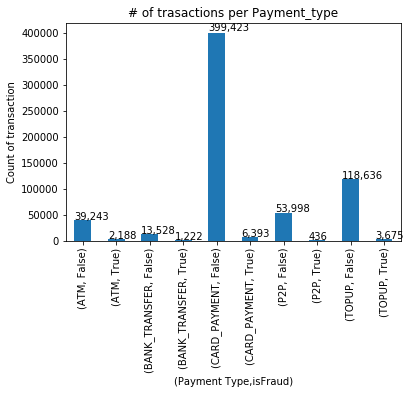

In [9]:
## figure out any difference in fraudument transactions in different payment type
ax = data.groupby(['type','is_fraudster']).size().plot(kind="bar")
ax.set_title("# of trasactions per Payment_type")
ax.set_xlabel("(Payment Type,isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

Text(0, 0.5, 'Count of transaction')

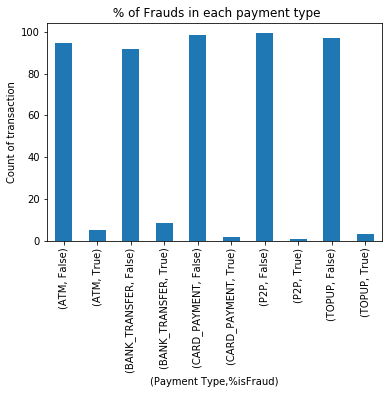

In [10]:
perc_entry = data.groupby(['type','is_fraudster']).size()
ax = perc_entry.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).plot(kind="bar")
ax.set_title(" % of Frauds in each payment type")
ax.set_xlabel("(Payment Type,%isFraud)")
ax.set_ylabel("Count of transaction")

#### Note: Above bar chart tells us that payment through bank_transfer has a comparably higher rate of frauds

Text(0, 0.5, 'Count of transaction')

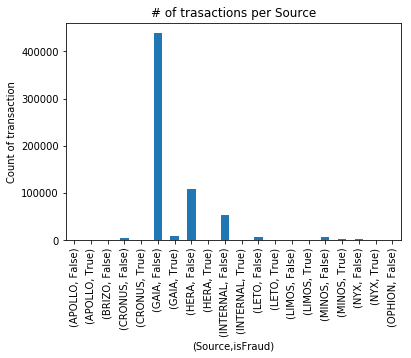

In [11]:
## figure out any difference in fraudument transactions for different source
ax = data.groupby(['source','is_fraudster']).size().plot(kind="bar")
ax.set_title("# of trasactions per Source")
ax.set_xlabel("(Source,isFraud)")
ax.set_ylabel("Count of transaction")


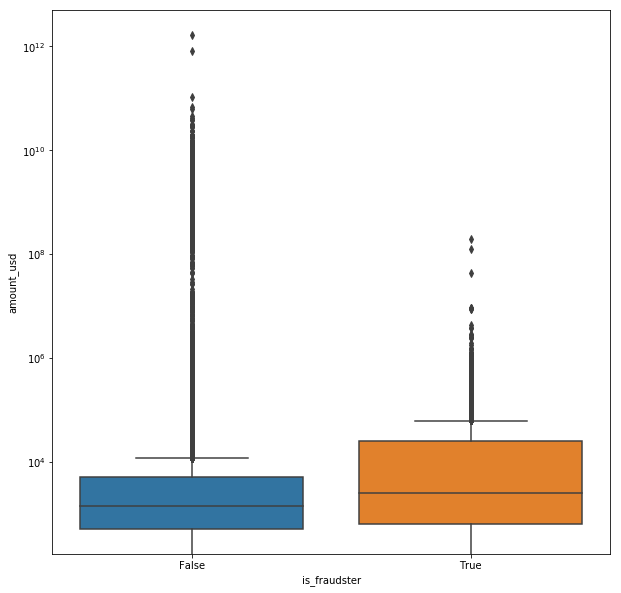

In [12]:
## Amount distribution for fraud trasaction or not
fig, ax = plt.subplots( figsize=(10, 10))
a = sns.boxplot(x = 'is_fraudster', y = 'amount_usd', data = data, ax=ax)
ax.set_yscale('log')

In [0]:
# extract month, weekday, and hour information
data['tran_year'] = data['tran_created'].apply(lambda x: x.year)
data['tran_month'] = data['tran_created'].apply(lambda x: x.month)
data['tran_day'] = data['tran_created'].apply(lambda x: x.day)
data['tran_weekday'] = data['tran_created'].apply(lambda x: x.dayofweek)
data['tran_hour'] = data['tran_created'].apply(lambda x: x.hour)


Text(0, 0.5, 'Count of transaction')

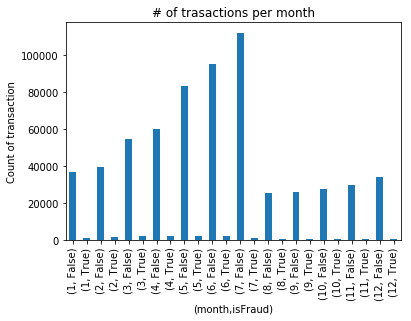

In [14]:
ax = data.groupby(['tran_month','is_fraudster']).size().plot(kind="bar")
ax.set_title("# of trasactions per month")
ax.set_xlabel("(month,isFraud)")
ax.set_ylabel("Count of transaction")

Text(0, 0.5, 'Count of transaction')

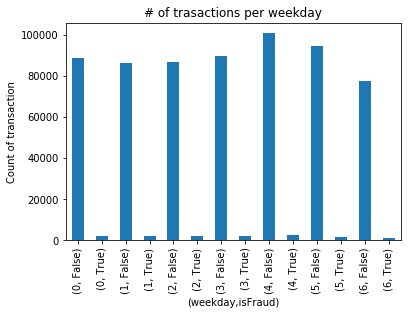

In [0]:
ax = data.groupby(['tran_weekday','is_fraudster']).size().plot(kind="bar")
ax.set_title("# of trasactions per weekday")
ax.set_xlabel("(weekday,isFraud)")
ax.set_ylabel("Count of transaction")

Text(0, 0.5, 'Count of transaction')

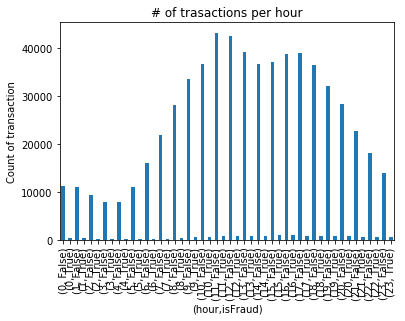

In [0]:
ax = data.groupby(['tran_hour','is_fraudster']).size().plot(kind="bar")
ax.set_title("# of trasactions per hour")
ax.set_xlabel("(hour,isFraud)")
ax.set_ylabel("Count of transaction")

##### Note: it's obvious to see that fraudulent transactions increase in the evening time  with all the transactions growing. 

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 5]

Text(0, 0.5, 'Count of transaction')

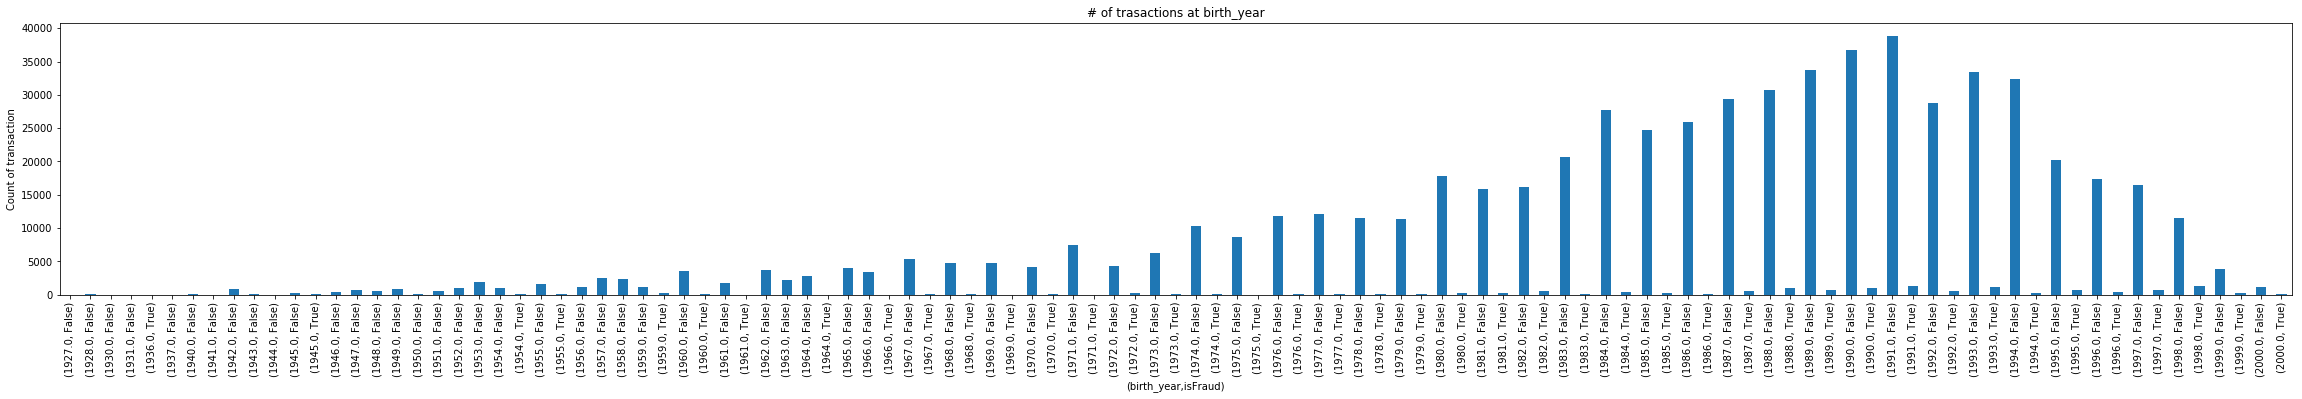

In [16]:

ax = data.groupby(['birth_year','is_fraudster']).size().plot(kind="bar")
ax.set_title("# of trasactions at birth_year")
ax.set_xlabel("(birth_year,isFraud)")
ax.set_ylabel("Count of transaction")


# Data Processing

In [17]:
def num_missing(x):
  return sum(x.isnull())

print ("Missing Vlaues per Column")
print (data.apply(num_missing,axis=0))


Missing Vlaues per Column
currency                        0
amount                          0
tran_state                      0
tran_created                    0
merchant_category          465586
merchant_country           205596
entry_method                    0
user_id                         0
type                            0
source                          0
tran_id                         0
amount_usd                      0
has_email                   49909
phone_country               49909
is_fraudster                49909
terms_version               75567
acc_created                 49909
country                     49909
birth_year                  49909
kyc                         49909
failed_sign_in_attempts     49909
tran_year                       0
tran_month                      0
tran_day                        0
tran_weekday                    0
tran_hour                       0
dtype: int64


#### As we can see that there're 49909 rows with na value, and these are without user information . We are going to delete these observations first as they only take a tiny proportion of our sample dataset and not help to future modeling.

In [18]:
data['is_fraudster'].value_counts()

False    624828
True      13914
Name: is_fraudster, dtype: int64

In [0]:
data1=data.dropna(subset=['has_email'])

In [0]:
data1.isnull().sum()



currency                        0
amount                          0
tran_state                      0
tran_created                    0
merchant_category          430065
merchant_country           191725
entry_method                    0
user_id                         0
type                            0
source                          0
tran_id                         0
amount_usd                      0
has_email                       0
phone_country                   0
is_fraudster                    0
terms_version               25658
acc_created                     0
country                         0
birth_year                      0
kyc                             0
failed_sign_in_attempts         0
dtype: int64


#### For the variable 'terms_version' , I'm  going to replace NA with date of "tran_created" assuming that the application version they used to created transaction always keep the lastest version.
#### However, these na observation will be removed with not considering the indexes they are under for 'merchant_category ' and 'merchant_country'. It's because of these observation take large proportion of our sample data set.

In [21]:

data1['tran_created']= pd.to_datetime(data1['tran_created'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
date_miss=data1['tran_created'][data1['terms_version'].isnull()]

In [23]:
data1['terms_version'].fillna(date_miss,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
data1.isnull().sum()

currency                        0
amount                          0
tran_state                      0
tran_created                    0
merchant_category          430065
merchant_country           191725
entry_method                    0
user_id                         0
type                            0
source                          0
tran_id                         0
amount_usd                      0
has_email                       0
phone_country                   0
is_fraudster                    0
terms_version                   0
acc_created                     0
country                         0
birth_year                      0
kyc                             0
failed_sign_in_attempts         0
tran_year                       0
tran_month                      0
tran_day                        0
tran_weekday                    0
tran_hour                       0
dtype: int64

# Feature Selection

In [0]:
## Eliminate columns shown large proportion of NA
data_v2 = data1.drop(['currency','amount','user_id','tran_id','phone_country','tran_created','merchant_category','merchant_country'],axis=1)

In [34]:
data_v2.dtypes

tran_state                         object
entry_method                       object
type                               object
source                             object
amount_usd                          int64
has_email                         float64
is_fraudster                       object
terms_version                      object
acc_created                datetime64[ns]
country                            object
birth_year                        float64
kyc                                object
failed_sign_in_attempts           float64
tran_year                           int64
tran_month                          int64
tran_day                            int64
tran_weekday                        int64
tran_hour                           int64
dtype: object

In [0]:
## extract categorical features to be numerical
obj_df= data_v2.select_dtypes(include=['object']).copy()
int_df = data_v2.select_dtypes(include=['int64']).copy()
float_df = data_v2.select_dtypes(include=['float64']).copy()

df_int_float = pd.concat([float_df,int_df],axis=1,join_axes= [int_df.index])

In [0]:
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
obj_df_trf=obj_df.astype(str).apply(le.fit_transform)

In [46]:
df_final = pd.concat([df_int_float,obj_df_trf], axis=1, join_axes=[df_int_float.index])
df_final.head()

,has_email,birth_year,failed_sign_in_attempts,amount_usd,tran_year,tran_month,tran_day,tran_weekday,tran_hour,tran_state,entry_method,type,source,is_fraudster,terms_version,country,kyc
0,1.0,1962.0,0.0,220,2017,12,20,2,12,1,1,2,3,0,25663,13,2
1,1.0,1995.0,0.0,2885,2017,12,20,2,12,1,1,2,3,0,25664,22,2
2,1.0,1985.0,0.0,1198,2017,12,20,2,12,1,1,2,3,0,25663,6,2
3,1.0,1974.0,0.0,249,2017,12,20,2,12,1,1,2,3,0,25664,13,2
4,1.0,1991.0,0.0,1101,2017,12,20,2,12,1,1,2,3,0,25663,12,2


# Modeling

In [2]:
x= df_final.drop('is_fraudster',axis =1)
y= df_final['is_fraudster']

NameError: ignored

In [1]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30,
                                                    random_state = 101)

NameError: ignored

In [0]:
## Train The model without Hyper-paprameter Yuning 
model = SVC() 
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions))

In [0]:
## Use GridsearchCV to do hyper-parameter tuning
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

In [0]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

In [0]:
grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions))

# Resampling